## Resumo do Capítulo 7: Projeto de Filtros FIR

O capítulo aborda técnicas de projeto de filtros FIR (Resposta ao Impulso Finita) com ênfase em fase linear. Os principais tópicos incluem:

1. **Introdução**:
   - Filtros FIR são estáveis e podem ter fase linear exata.
   - Aplicações incluem filtragem seletiva em frequência, diferenciadores e transformadores de Hilbert.

2. **Especificações**:
   - **Absolutas**: Tolerâncias de ripple ($\delta_1$ no passband, $\delta_2$ no stopband).
   - **Relativas (dB)**:
     $$
     R_p = -20 \log_{10}\left(\frac{1 - \delta_1}{1 + \delta_1}\right), \quad A_s = -20 \log_{10}\left(\frac{\delta_2}{1 + \delta_1}\right)
     $$

3. **Propriedades de Fase Linear**:
   - **Tipo I**: Simétrico, $M$ ímpar (adequado para passa-baixas).
   - **Tipo II**: Simétrico, $M$ par (não adequado para passa-altas).
   - **Tipo III**: Antissimétrico, $M$ ímpar (diferenciadores/Hilbert).
   - **Tipo IV**: Antissimétrico, $M$ par (diferenciadores/Hilbert).

4. **Técnicas de Projeto**:
   - **Janelamento**: Multiplicação da resposta ao impulso ideal por uma janela (ex: Hamming, Kaiser).
   - **Amostragem em Frequência**: Amostragem da resposta em frequência ideal + ajuste de amostras de transição.
   - **Equiripple (Ótimo)**: Algoritmo de Parks-McClellan para erro máximo mínimo (usando `firpm` no MATLAB).

### Simulações em Python
Abaixo, implementações em Python das técnicas principais:

### Função Kaiserord
Essa função serve para determinar os parâmetros essenciais na construção de um filtro FIR com janela de Kaiser. Com base na atenuação desejada (As) e na largura da faixa de transição (width), ela calcula a ordem do filtro (M) e o parâmetro beta, que definem a precisão e a forma do filtro para atender às especificações desejadas.

In [4]:
def kaiserord(As, width):
    beta = 0.1102 * (As - 8.7) if As > 50 else 0.5842 * (As - 21)**0.4 + 0.07886 * (As - 21)
    M = int(np.ceil((As - 7.95) / (2.285 * 2 * np.pi * width)) + 1)
    return M, beta

#### 1. Conversão de Especificações e Exemplo 7.1

In [6]:
import numpy as np

def db2delta(Rp, As):
    delta1 = (10**(Rp/20) - 1) / (10**(Rp/20) + 1)
    delta2 = (1 + delta1) * 10**(-As/20)
    return delta1, delta2

def delta2db(delta1, delta2):
    Rp = -20 * np.log10((1 - delta1) / (1 + delta1))
    As = -20 * np.log10(delta2 / (1 + delta1))
    return Rp, As

# Exemplo 7.1:
delta1, delta2 = 0.01, 0.001
Rp, As = delta2db(delta1, delta2)
print(f"Rp = {Rp:.2f} dB, As = {As:.2f} dB")

Rp = 0.17 dB, As = 60.09 dB


#### 2. Projeto por Janelamento (Exemplo 7.8)

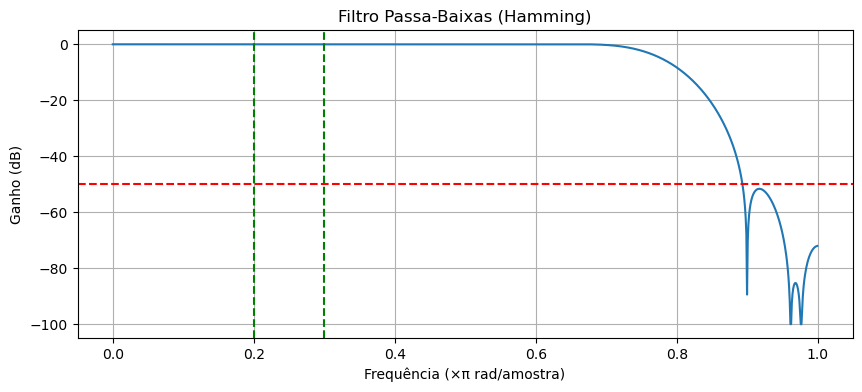

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz

# Especificações
wp = 0.2 * np.pi  # Borda do passband
ws = 0.3 * np.pi  # Borda do stopband
Rp = 0.25         # Ripple no passband (dB)
As = 50           # Atenuação no stopband (dB)

# Converter para deltas
delta1, delta2 = db2delta(Rp, As)

# Estimativa da ordem (Kaiser)
M, beta = kaiserord(As, (ws - wp)/np.pi)
M = M if M % 2 == 1 else M + 1  # Garantir ímpar

# Projeto com janela de Hamming
h_hamming = firwin(M, (wp + ws)/2, window='hamming', fs=2)

# Resposta em frequência
w, H = freqz(h_hamming, 1, worN=1024)
H_db = 20 * np.log10(np.maximum(np.abs(H), 1e-5))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(w/np.pi, H_db)
plt.axhline(-As, color='r', linestyle='--')
plt.axvline(wp/np.pi, color='g', linestyle='--')
plt.axvline(ws/np.pi, color='g', linestyle='--')
plt.title("Filtro Passa-Baixas (Hamming)")
plt.xlabel("Frequência (×π rad/amostra)")
plt.ylabel("Ganho (dB)")
plt.grid(True)
plt.show()


#### 3. Projeto Equiripple (Exemplo 7.23)

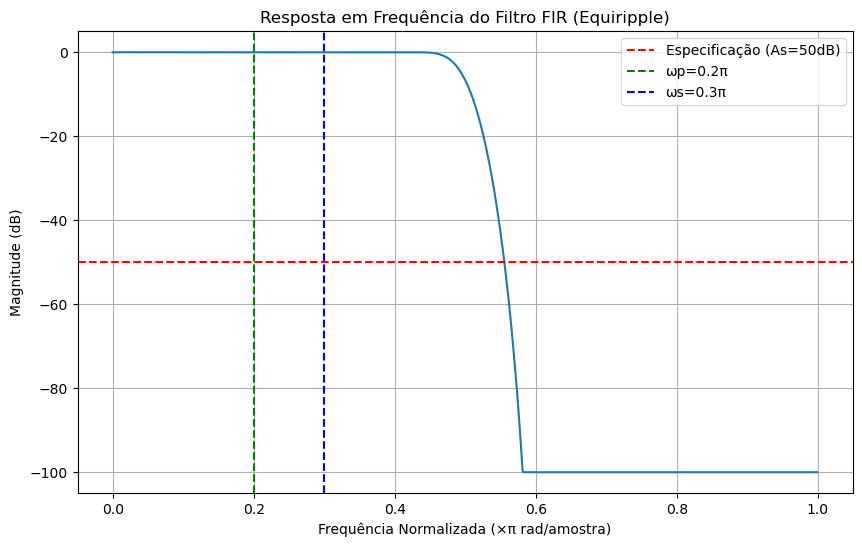

Ordem do filtro: M = 131


In [10]:
import numpy as np
from scipy.signal import remez, freqz
import matplotlib.pyplot as plt

# Parâmetros do filtro
wp = 0.2  # Frequência de passagem normalizada (0.2π rad/amostra)
ws = 0.3  # Frequência de stop normalizada (0.3π rad/amostra)
Rp = 0.25  # Ripple na banda de passagem (dB)
As = 50    # Atenuação na banda de stop (dB)

# Converter especificações para forma absoluta
def db2delta(Rp, As):
    delta1 = (10**(Rp/20) - 1)/(10**(Rp/20) + 1)
    delta2 = (1 + delta1)*10**(-As/20)
    return delta1, delta2

delta1, delta2 = db2delta(Rp, As)

# Estimativa da ordem do filtro 
transition_width = ws - wp
M = int(np.ceil((-20*np.log10(np.sqrt(delta1*delta2)) - 13)/(2.324*transition_width)))
M = M + 1 if M % 2 == 0 else M

# Projeto do filtro usando Remez
# As bandas devem ser especificadas em relação a 0.5 (Nyquist)
bands = [0, wp, ws, 0.5]  # 0.5 corresponde a π rad/amostra
desired = [1, 0]         # Ganhos desejados
weights = [delta2/delta1, 1]  # Pesos relativos

try:
    h_equiripple = remez(M, bands, desired, weight=weights, fs=1.0)
except ValueError as e:
    print(f"Erro no projeto: {e}")
    # Abordagem alternativa
    bands = [0, wp*2, ws*2, 1.0]  # Escalonado para fs=2
    h_equiripple = remez(M, bands, desired, weight=weights, fs=2.0)

# Resposta em frequência
w, H = freqz(h_equiripple, 1, worN=1024)
H_db = 20*np.log10(np.maximum(np.abs(H), 1e-5))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(w/np.pi, H_db)
plt.axhline(-As, color='r', linestyle='--', label=f'Especificação (As={As}dB)')
plt.axvline(wp, color='g', linestyle='--', label=f'ωp={wp}π')
plt.axvline(ws, color='b', linestyle='--', label=f'ωs={ws}π')
plt.title('Resposta em Frequência do Filtro FIR (Equiripple)')
plt.xlabel('Frequência Normalizada (×π rad/amostra)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.show()

print(f"Ordem do filtro: M = {M}")

#### 4. Transformador de Hilbert (Exemplo 7.28)

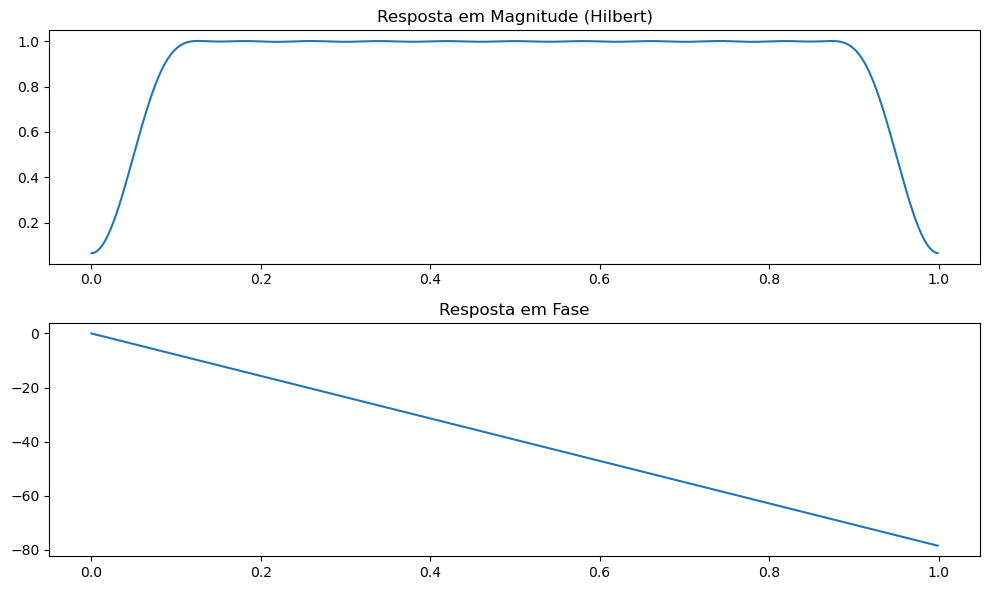

In [12]:
# Projeto de Hilbert (Tipo III)
M_hilbert = 51  # Ímpar (Tipo III)
h_hilbert = firwin(M_hilbert, [0.05, 0.95], window='hamming', fs=2, pass_zero=False)

# Resposta em frequência
w, H_hilb = freqz(h_hilbert, 1, worN=1024)
phase = np.unwrap(np.angle(H_hilb))

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
ax1.plot(w/np.pi, np.abs(H_hilb))
ax1.set_title("Resposta em Magnitude (Hilbert)")
ax2.plot(w/np.pi, phase)
ax2.set_title("Resposta em Fase")
plt.tight_layout()
plt.show()


# 🎥 Vídeos sobre Filtros Digitais FIR

## Vídeo 1 – Filtros Digitais (UNIVESP)
https://youtu.be/CaXR0WDB-Ww?si=jwJMxISzX8ZILk-C

## Vídeo 2 – Filtros FIR (UNIVESP)
https://youtu.be/5LTRzMNpIPo?si=Snhf4ORbfv4WEM2D

## Vídeo 4 – Projeto de Filtros (UNIVESP)
https://youtu.be/rgcbsLyf9mM?si=HPAAMyfTfOXQkgmL

## Vídeo 5 – Projetanto Filtros FIR (UNIVESP)
https://youtu.be/FHHYfsVyRIE?si=7u-jgppVOdxYb8EY